# Wstęp

Celem projektu jest wykonanie modele ekonometrycznego przewidującego zużycie prądu elektrycznego
na Słowacji w okresie 2008 - 2019.

Do budowy modelu użyliśmy danych z ogólnodostępnych portali statystycznych

- Eurostat
- FRED
- OECD

Dane wejściowe miały częstotliwość kwartalną (czasem potrzebne były przekształcenia: agregacja, przyjęcie
stałej wartości w okresie).

# Dane
**Zmienna objaśniana**:

ilość dostarczoneej energii elektrycznej na Słowacji w
dane kwartalne 2008-2019

**Zmienne objaśniające**:

- `gdp` - PKB Słowacji - dane kwartalne
- `cooling` - Liczba stopniodni chłodniczych na Słowacji - dane miesięczne
- `heating` - Liczba stopniodni grzewczych na Słowacji - dane miesięczne
- `brent` - cena ropy Brent - dane miesięczne
- `dubai` - cena ropy Dubaj - dane miesięcnze
- `disp_income` - Procentowa zmiana dochodu rozporządzalnego na Słowacji - dane roczne
- `electricity_hh` - cena prądu dla gospodarstw domowych na Słowacji (uwzględniając podatki) - dane semestralne
- `electricity_nhh` - cena prądu dla przedsiębiorców na Słowacji (uwzględniając podatki) - dane semestralne
- `gas_hh` - cena gazu dla gospodarstw domowych na Słowacji (uwzględniając podatki) - dane semestralne
- `gas_nhh` - cena gazu dla przedsiębiorców na Słowacji (uwzględniając podatki) - dane semestralne


# Ekonomiczne podstawy doboru zmiennych

Dobór jako zmiennyc w modelu takich wielkości jak powyżej można uzasadnić na gruncie
ekonomicznym. Najprostszym do wytłumaczenia jest wpływ PKB Słowacji - produkt krajowy brutto
to suma wwartości dóbr wytworzonych na terenie danego kraju, a wytworzenie produktów i świadczenie
usług przeważnie wiąże się ze zużyciem energii, często elektrycznej. Jeśli chodzi o cenę
energii elektryczn, jej dołączenie jest poczywiste - popyt i cena są mocno powiązane
(prawo popytu). Dochód rozporządzalny również jest istotną wielkością, ponieważ popyt
zależny jest od dochodu jednostek - często przredstawia się go jako funkcję tego dochodu,
jego wielkość w przypadku dóbr normalnych rośnie wraz ze wzrtostem cochodu. Istotną informacją jes
temperatura powietrza, ponieważ do ogrzania czy schłodzenia przestrzeni potrzebna jest energia - część
zapotrzebowania pokrywana jest przez energię elektryczną. Oprócz twymienionych tego dodaliśmy
też do zbioru potenjclanych zmiennych ceny ropy i ceny gazu, gdyż są to po częśći dobra komplementarne
do prądu elektrycznego - z nich również uzyskiwana jest energia, dobra te mogą się wzajemnie zastępować
w niektórych zastosowaniach (np. ogrzewanie budynków gazem, samochody elektryczne i spalinowe).

# Przygotowanie środowiska

In [1]:
# przygotowanie bibliotek
import numpy as np
import scipy as sp
import statsmodels.api as sm
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
import os
from pprint import pprint
from math import sqrt
import networkx as nx
matplotlib.rcParams['figure.figsize'] = [10, 10]

In [2]:
# wczytanie danych oraz oddzielenie zmiennej objaśnianej
data = pd.read_csv("./data/combined2.csv")
y = data.iloc[:,-1].to_frame()
data.drop("supply", axis = 1, inplace=True)
data.drop("date", axis = 1, inplace=True)

In [3]:
# ustawienie parametrów rozkładów
alpha = 0.05
T = stats.t.ppf(0.95, 29)
n = len(data)

## Wykluczanie quasi-stałych

In [4]:
Vs = dict()
for col in data.iloc[:,0:]:
    Vs[col] = np.sqrt(np.sum((data[col]-np.mean(data[col]))**2)/n)/np.mean(data[col])
pprint(Vs)

{'brent': 0.3254543165135201,
 'cooling': 1.7931201914923194,
 'disp_income': 1.1276351622976837,
 'dubai': 0.32203341381815503,
 'electricity_hh': 0.05340965710269931,
 'electricity_nhh': 0.05500574560771167,
 'gas_hh': 0.065832865633243,
 'gas_nhh': 0.10566838057096069,
 'gdp': 0.1260286033716181,
 'heating': 0.7507999634356447}


In [5]:
data.drop([k for k, v in Vs.items() if v < 0.15], axis = 1, inplace = True)
data

,cooling,heating,brent,dubai,disp_income
0,0.00,1420.97,96.936667,91.109503,6.630723
1,4.26,361.62,121.396667,116.668297,6.630723
2,11.28,162.79,114.396667,113.468427,6.630723
3,0.00,1099.30,54.660000,53.603920,6.630723
4,0.00,1613.69,44.433333,44.439939,1.611855
5,0.64,304.47,58.696667,58.954935,1.611855
6,22.50,48.02,68.200000,68.067344,1.611855
7,0.00,1216.38,74.630000,75.455738,1.611855
8,0.00,1623.49,76.250000,75.878379,2.279022
9,7.70,379.14,78.510000,77.862424,2.279022


## Obliczanie korelacji

In [6]:
data_with_y = data.copy()
data_with_y['electricity_hh'] = y.values

In [7]:
corr_mat = data_with_y.corr()
R_v = corr_mat.iloc[:-1, -1]
R_mat = corr_mat.iloc[:-1, :-1]

In [8]:
R_v

cooling       -0.409859
heating        0.796569
brent          0.167408
dubai          0.171249
disp_income   -0.061210
Name: electricity_hh, dtype: float64

In [9]:
R_mat

,cooling,heating,brent,dubai,disp_income
cooling,1.000000,-0.610182,-0.043749,-0.041843,0.020799
heating,-0.610182,1.000000,-0.082624,-0.086824,-0.035670
brent,-0.043749,-0.082624,1.000000,0.998401,-0.498584
dubai,-0.041843,-0.086824,0.998401,1.000000,-0.492874
disp_income,0.020799,-0.035670,-0.498584,-0.492874,1.000000


In [10]:
r_min = sqrt(T*T/(T*T+n-2))
print(f"{r_min = }")
R_mat[abs(R_mat) < r_min] = 0
R_mat

r_min = 0.2430127215814742


,cooling,heating,brent,dubai,disp_income
cooling,1.000000,-0.610182,0.000000,0.000000,0.000000
heating,-0.610182,1.000000,0.000000,0.000000,0.000000
brent,0.000000,0.000000,1.000000,0.998401,-0.498584
dubai,0.000000,0.000000,0.998401,1.000000,-0.492874
disp_income,0.000000,0.000000,-0.498584,-0.492874,1.000000


# Dobór zmiennych

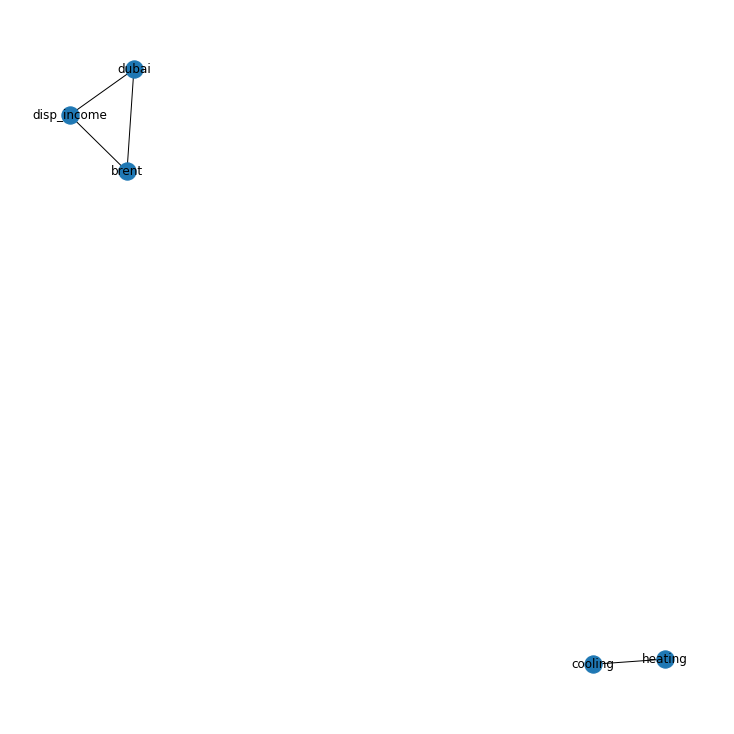

In [11]:
adj_mat = R_mat.copy()
adj_mat[adj_mat != 0] = 1
adj_mat = adj_mat.to_numpy()
for i in range(adj_mat.shape[0]):
    adj_mat[i, i] = 0

G = nx.Graph(adj_mat)
pos=nx.spring_layout(G)
nx.draw(G, pos=pos)
nx.draw_networkx_labels(G, pos=pos, labels = dict(zip(range(len(R_mat.columns)), list(R_mat.columns))))
plt.show()

Należy wybrać dwie zmienne (delikatnie zmienione przez późniejsze testy):
1. `heating`
2. `brent`

In [12]:
#data["heating2"] = data["heating"] ** 2
data_final = data[["dubai", "heating"]].to_numpy()
reg = sm.OLS(y, data_final).fit()


In [13]:
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 supply   R-squared (uncentered):                   0.944
Model:                            OLS   Adj. R-squared (uncentered):              0.942
Method:                 Least Squares   F-statistic:                              390.3
Date:                Wed, 15 Jun 2022   Prob (F-statistic):                    1.40e-29
Time:                        14:18:28   Log-Likelihood:                         -369.70
No. Observations:                  48   AIC:                                      743.4
Df Residuals:                      46   BIC:                                      747.1
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            20.6624      1.457     14.184      0.000      17.730      23.595
x2             0.6634      0.121      5.482      0.000       0.420       0.907
==============================================================================
Omnibus:                        4.317   Durbin-Watson:                   0.509
Prob(Omnibus):                  0.115   Jarque-Bera (JB):                2.141
Skew:                          -0.220   Prob(JB):                        0.343
Kurtosis:                       2.063   Cond. No.                         18.1
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

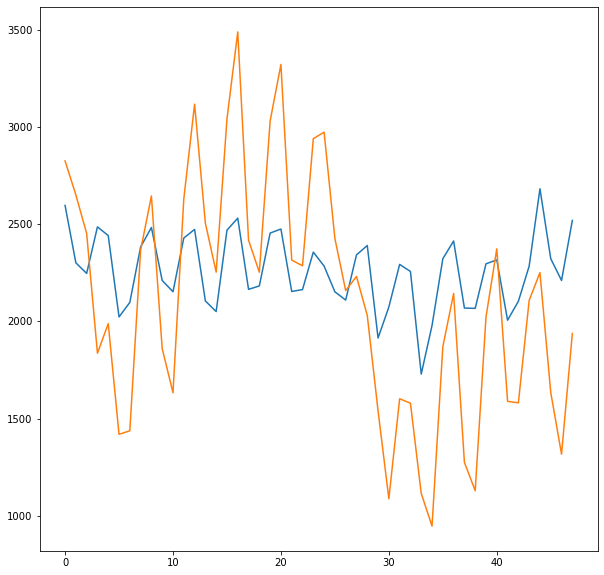

In [14]:
plt.plot(y)
plt.plot(reg.predict(data[["dubai", "heating"]].to_numpy()))

In [15]:
reg.mse_model

116798471.26332879